In [1]:
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [2]:
class consts:
    g = 9.81                 # m/s^2
    pi = 3.14159
    mu_0 = 4 * pi * 10 ** -7 # N / A^2

class setup:
    dummy = 0

    wb_SN = 0.0072     # m^2
    wb_div = 0.1       # mWb

    al_d = 9.9         # mm
    cu_d = 9.9         # mm
    gr_brk_d = 9.9     # mm
    gr_sol_d = 8.0     # mm
    wr_d = 3.2         # mm

    em_supply_err = lambda x: 0.005 * x + 0.02  # A
    tl_err = lambda x: 0.05 * x + 10        # mTl
    wb_err = lambda x: 0.015 * x + 0.05     # mWb
    d_err = lambda: 0.05                    # mm
    P_err = lambda: 1.0 * consts.g / 1000   # mN


## Electromagnet calibration

In [3]:
xls = {
    'I, A' : 'I',
    'Phi, divisions' : 'Phi_div',
    'B, mTl' : 'B'
}

em_data = mipt.read_excel("data/341.ods", usecols=['A', 'B', 'C', 'D'], header=[0, 1], nrows=10)
em_data = mipt.map_excel(em_data, xls)

wb_B = em_data[('Webermeter', 'Phi_div')] * setup.wb_div / setup.wb_SN

em_fmt = {
    'Webermeter' : ['Веберметр'],
    'Teslameter' : ['Тесламетр'],
    ('Webermeter', 'I') : ['$I$, А', '{:.2f}', 0],
    ('Webermeter', 'Phi_div') : ['$\Phi$, деления', '{:.1f}', 0],
    ('Webermeter', 'B') : ['$B$, мТл', '{:.0f}', 0],
    ('Teslameter', 'I') : ['$I$, А', '{:.2f}', 0],
    ('Teslameter', 'B') : ['$B$, мТл', '{:.0f}', 0],
}

em_tbl = mipt.table(em_data, em_fmt)
em_tbl.insert(2, ('Webermeter', 'B'), wb_B)
em_tbl.rename().get_data().style.to_latex('gen/electromagnet.tex')
em_tbl.get_data()

Webermeter                     Teslameter     
           I Phi_div           B          I    B
0        0.3     6.5   90.277778        0.3  100
1        0.6    12.5  173.611111        0.6  190
2        0.9    19.0  263.888889        0.9  279
3        1.2    26.0  361.111111        1.2  380
4        1.5    33.0  458.333333        1.5  466
5        1.8    39.0  541.666667        1.8  550
6        2.1    44.0  611.111111        2.1  630
7        2.4    50.0  694.444444        2.4  705
8        2.7    56.0  777.777778        2.7  770
9        3.0    61.0  847.222222        3.0  820

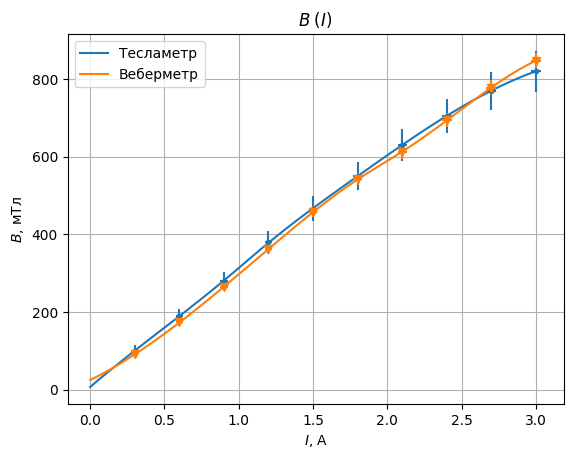

In [4]:
def interp_spl(x, y):
    return UnivariateSpline(x, y)

d = em_tbl.get_data()

x, y, tl_equ = mipt.plot(
    d[('Teslameter', 'I')],
    d[('Teslameter', 'B')],
    xerr = setup.em_supply_err(d[('Teslameter', 'I')]),
    yerr = setup.tl_err(d[('Webermeter', 'B')]),
    x_min = 0,
    func = interp_spl,
    label = 'Тесламетр',
    unique_marker = True
)

x, y, wb_equ = mipt.plot(
    d[('Webermeter', 'I')],
    d[('Webermeter', 'B')],
    xerr = setup.em_supply_err(d['Webermeter', 'I']),
    yerr = setup.wb_err(d['Webermeter', 'Phi_div'] * setup.wb_div) / setup.wb_SN,
    x_min = 0,
    func = interp_spl,
    label = 'Веберметр',
    unique_marker = True
)

plt.title("$B \; (I)$")
plt.xlabel("$I$, А")
plt.ylabel("$B$, мТл")
plt.grid(True)
plt.legend()

plt.savefig("gen/electromagnet_BI.pdf")


## Forces in magnetic field

In [5]:
xls = {
    'I, A' : 'I',
    'dP_straight, mg' : 'dP_s',
    'dP_back, mg' : 'dP_b'
}

def read_and_convertP(cols):
    data = mipt.read_excel("data/341.ods", usecols=cols, header=[0, 1], nrows=10)
    data = mipt.map_excel(data, xls)

    # Convert to mN
    name = data.columns[0][0]
    print(name)
    data[(name, 'dP_s')] *= consts.g / 1000
    data[(name, 'dP_b')] *= consts.g / 1000

    # Convert I to B
    data.insert(1, (name, 'B'), tl_equ(data[(name, 'I')]))
    del data[(name, 'I')]

    return data

cu_data = read_and_convertP(['F', 'G', 'H'])
al_data = read_and_convertP(['J', 'K', 'L'])
gr_brk_data = read_and_convertP(['N', 'O', 'P'])
gr_data = read_and_convertP(['R', 'S', 'T'])
wr1_data = read_and_convertP(['V', 'W', 'X'])
wr2_data = read_and_convertP(['Z', 'AA', 'AB'])
wr_dbl_data = read_and_convertP(['AD', 'AE', 'AF'])
cu_data

Cuprum
Aluminium
Graphite (broken)
Graphite (solid)
Wolfram1 (single)
Wolfram2 (single)
Wolfram (doubled)


Cuprum                  
            B     dP_s     dP_b
0  100.182045 -0.00981 -0.00981
1  189.083894 -0.01962 -0.01962
2  280.896035 -0.03924 -0.02943
3  377.966268 -0.04905 -0.05886
4  467.146056 -0.07848 -0.07848
5  549.714866 -0.10791 -0.10791
6  630.003542 -0.13734 -0.12753
7  705.026206 -0.15696 -0.16677
8  769.967805 -0.20601 -0.20601
9  820.013282 -0.23544 -0.23544

In [6]:
fmt = {
    '<x>':    ['$\overline{x}$', '{:.2e}'],
    'sx':     ['$\sigma_x^2$',   '{:.2e}'],
    '<y>':    ['$\overline{y}$', '{:.2e}'],
    'sy':     ['$\sigma_y^2$',   '{:.2e}'],
    'rxy':    ['$r_{xy}$',       '{:.2e}'],
    'a':      ['$a$',            '{:.2e}'],
    'da':     ['$\Delta a$',     '{:.2e}'],
    'b':      ['$b$',            '{:.2e}'],
    'db':     ['$\Delta b$',     '{:.2e}'],
}

def plot_it(d, label, func = mipt.interp_linear):
    name = d.columns[0][0]
    x, y, equ = mipt.plot(
        d[(name, 'B')] ** 2,
        d[(name, 'dP_s')],
        xerr = 2 * d[(name, 'B')] * setup.tl_err(d[(name, 'B')]),
        yerr = setup.P_err(),
        x_min = 0,
        func = func,
        label = "{}, рост".format(label),
        unique_marker = True
    )
    x_clean = x
    y_clean = y
    x, y, equ = mipt.plot(
        d[(name, 'B')] ** 2,
        d[(name, 'dP_b')],
        xerr = 2 * d[(name, 'B')] * setup.tl_err(d[(name, 'B')]),
        yerr = setup.P_err(),
        x_min = 0,
        func = func,
        label = "{}, падение".format(label),
        unique_marker = True
    )
    x_clean.combine(x, (lambda x1, x2: x1 if x1 < x2 else x2))
    y_clean.combine(y, (lambda x1, x2: x1 if x1 < x2 else x2))
    
    return mipt.mnk(x_clean, y_clean, fmt = fmt)


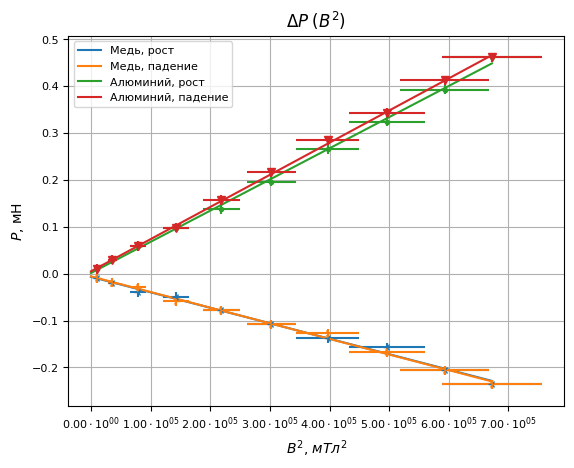

In [9]:
fig = plt.figure()
ax = fig.add_subplot()

mnk_cu = plot_it(cu_data, "Медь")
mnk_al = plot_it(al_data, "Алюминий")

def xfmt(x, y):
    return '${:.2e} }}$'.format(x).replace('e+', '\cdot 10^{')

ax.xaxis.set_major_formatter(ticker.FuncFormatter(xfmt))
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

plt.title("$\Delta P \; (B^2)$")
plt.xlabel("$B^2$, $мТл^2$")
plt.ylabel("$P$, мН")
plt.grid(True)
plt.legend(fontsize = 8)

plt.savefig("gen/cu_al.pdf")
mnk_cu.to_latex("gen/cu_mnk.tex")
mnk_al.to_latex("gen/al_mnk.tex")


/home/futherus/.local/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/futherus/.local/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,294720.073358,5.065793e+10,1.635327,0.955625,217842.167147,0.000004,2.156571e-07,0.367955,0.079973


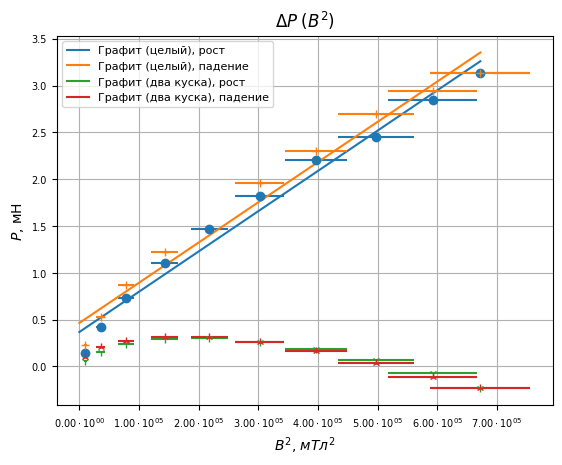

In [8]:
fig = plt.figure()
ax = fig.add_subplot()

mnk_gr = plot_it(gr_data, "Графит (целый)")
mnk_gr_brk = plot_it(gr_brk_data, "Графит (два куска)", func=None)

def xfmt(x, y):
    return '${:.2e} }}$'.format(x).replace('e+', '\cdot 10^{')

ax.xaxis.set_major_formatter(ticker.FuncFormatter(xfmt))
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)

plt.title("$\Delta P \; (B^2)$")
plt.xlabel("$B^2$, $мТл^2$")
plt.ylabel("$P$, мН")
plt.grid(True)
plt.legend(fontsize = 8)

plt.savefig("gen/gr.pdf")
mnk_gr.to_latex("gen/gr_mnk.tex")
mnk_gr.get_data()

4.631309013667029e-07
2.480690605940064e-07


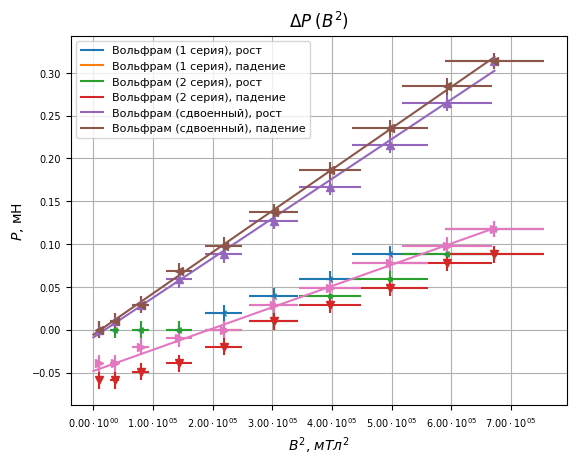

In [9]:
fig = plt.figure()
ax = fig.add_subplot()

mnk_wr1 = plot_it(wr1_data, "Вольфрам (1 серия)", func = None)
mnk_wr2 = plot_it(wr2_data, "Вольфрам (2 серия)", func = None)
mnk_wr_dbl = plot_it(wr_dbl_data, "Вольфрам (сдвоенный)")

def xfmt(x, y):
    return '${:.2e} }}$'.format(x).replace('e', '\cdot 10^{').replace('+', '')

ax.xaxis.set_major_formatter(ticker.FuncFormatter(xfmt))
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)

plt.title("$\Delta P \; (B^2)$")
plt.xlabel("$B^2$, $мТл^2$")
plt.ylabel("$P$, мН")
plt.grid(True)
plt.legend(fontsize = 8)

plt.savefig("gen/wr_dbl.pdf")

d = wr1_data
name = d.columns[0][0]
x, y, equ = mipt.plot(
        d[(name, 'B')] ** 2,
        d[(name, 'dP_b')],
        xerr = 2 * d[(name, 'B')] * setup.tl_err(d[(name, 'B')]),
        yerr = setup.P_err(),
        begin = 3,
        x_min = 0,
        func = mipt.interp_linear,
        label = "{}, падение".format('label'),
        unique_marker = True
)
mnk_wr1 = mipt.mnk(x, y)

mnk_wr_dbl.to_latex("gen/wr_dbl_mnk.tex")
print(float(mnk_wr_dbl.get_data()['a']))
print(float(mnk_wr1.get_data()['a']))


In [10]:
def eval_chi(name, mnk_val, d, n_rods):
    m = mnk_val.get_data()
    S = n_rods * consts.pi * d ** 2 / 4
    S_err = 2 * (setup.d_err() / d) * S

    # print(float(m['a']))
    chi = (float(m['a']) * 1000) * 2 * consts.mu_0 / (S / 1000**2)
    chi_err = abs(chi * ( (S_err / S)**2 + (float(m['da']) / float(m['a']))**2 )**0.5)

    print("{}: chi = ({:.2e} +- {:.2e})".format(name, chi, chi_err))

    return chi


In [11]:
chi_cu = eval_chi('Cu', mnk_cu, setup.cu_d, 1)
print('Cu ref: chi = {:.2e}\n'.format(-9.63 * 10**-6))

chi_al = eval_chi('Al', mnk_al, setup.al_d, 1)
print('Al ref: chi = {:.2e}\n'.format(2.2 * 10**-5))

chi_gr = eval_chi('Gr', mnk_gr, setup.gr_sol_d, 1)
print('Gr_parallel ref: chi = {:.2e}'.format(6.1 * 10**-4))
print('Gr_perp     ref: chi = {:.2e}\n'.format(1.4 * 10**-5))

chi_wr = eval_chi('Wr (doubled)', mnk_wr_dbl, setup.wr_d, 2)
print('Wr ref: chi = {:.2e}\n'.format(8.84 * 10**-5))

Cu: chi = (-1.08e-05 +- 3.09e-07)
Cu ref: chi = -9.63e-06

Al: chi = (2.17e-05 +- 3.93e-07)
Al ref: chi = 2.20e-05

Gr: chi = (2.15e-04 +- 1.11e-05)
Gr_parallel ref: chi = 6.10e-04
Gr_perp     ref: chi = 1.40e-05

Wr (doubled): chi = (7.24e-05 +- 2.61e-06)
Wr ref: chi = 8.84e-05



In [5]:
19250 * 0.28 * 10**-10

5.390000000000002e-07

In [ ]:
59.0 * 10**-6 / 100**3 * 